In [21]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dense, LSTM, Activation
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.optimizers import Adam, RMSprop
from unidecode import unidecode
from keras.layers.embeddings import Embedding

%matplotlib inline

In [2]:
from nltk.tokenize import word_tokenize
from nltk import bigrams, FreqDist
from math import log

In [3]:
import lyricsgenius

genius = lyricsgenius.Genius("8C8ZjZRD9R1-ftPYBpLYAFya4dO71sB_6Q1ZJ5bgnLuTpxzqQl84NA9mW0HRJrIr")

genius.verbose = False # Turn off status messages
genius.remove_section_headers = True # Remove section headers (e.g. [Chorus]) from lyrics when searching
genius.skip_non_songs = False # Include hits thought to be non-songs (e.g. track lists)
genius.excluded_terms = ["(Remix)", "(Live)"] # Exclude songs with these words in their title

In [4]:
artist = genius.search_artist("Eminem", max_songs=2)

In [5]:
artist.save_lyrics(extension='txt')

Lyrics_Eminem.txt already exists. Overwrite?
(y/n): y
Wrote `Lyrics_Eminem.txt`


In [6]:
# preprocessing data
dataset = open("Lyrics_Eminem.txt", 'r+')
train_data = dataset.read().lower().replace(',',' ').replace('.',' ').replace('?',' ').replace('!',' ').replace(':',' ').replace(';',' ').replace('   ',' ').replace('/',' ').split("\n")

In [9]:
#Here I uploaded one song "Stan" used as test data
dataset2 = open("test_song.txt", 'r+')
test_data = dataset2.read().lower().replace(',',' ').replace('.',' ').replace('?',' ').replace('!',' ').replace(':',' ').replace(';',' ').replace('   ',' ').replace('/',' ').split("\n")

### unigram
1. smoothing method: add one
2. In order to minimize the errors, when calculate perplexity, parameters converted into logarithm and then accumulated.

In [10]:
# Training
unigramsDist = FreqDist()  # uni-gram词频数字典
for i in train_data:
    sWordFreq = FreqDist(word_tokenize(i))  # 每一句的词频数字典
    for j in sWordFreq:
        if j in unigramsDist:
            unigramsDist[j] += sWordFreq[j]
        else:
            unigramsDist[j] = sWordFreq[j]

In [11]:
# Testing
# add words which not occur in test data set
for i in test_data:
    word = word_tokenize(i)  # dictionary (word frequency in each sentence)
    for j in word:
        if j not in unigramsDist:
            unigramsDist[j] = 0

In [12]:
# count to frequency  smoothing: add one # unigramsDist.B()
s = unigramsDist.N() + unigramsDist.B()
unigramsFreq = FreqDist()
for i in unigramsDist:
    unigramsFreq[i] = (unigramsDist[i] + 1) / s

In [13]:
ppt = []
for sentence in test_data:
    logprob = 0
    wt = 0
    for word in word_tokenize(sentence):
        if word in unigramsFreq:
            logprob += log(unigramsFreq[word],2)
            wt += 1
    if wt > 0:
        ppt.append([sentence,pow(2,-(logprob/wt))])

In [14]:
temp = 0
for i in ppt:
    temp += i[1]
print("The perplexity of unigram is:", temp/len(ppt))

The perplexity of unigram is: 504.0672176830519


### bigram
(same method as unigram)

In [15]:
w2gram = {}     # all the number of 2-gram type words begin with 'w' 
bigramsDist = FreqDist()

for sentence in train_data:
    sWordFreq = FreqDist(bigrams(word_tokenize(sentence)))
    for j in sWordFreq:
        if j in bigramsDist:
            bigramsDist[j] += sWordFreq[j]
        else:
            bigramsDist[j] = sWordFreq[j]
            if j[0] in w2gram:
                w2gram[j[0]] += 1
            else:
                w2gram[j[0]] = 1

In [16]:
#test part
for sentence in test_data:
    word = bigrams(word_tokenize(sentence))
    for j in word:
        if j not in bigramsDist:
            bigramsDist[j] = 0
            
            if j[0] in w2gram:
                w2gram[j[0]] += 1
            else:
                w2gram[j[0]] = 1

In [17]:
history = {}
for i in bigramsDist:
    if i[0] in history:
        history[i[0]] += bigramsDist[i]
    else:
        history[i[0]] = bigramsDist[i]
bigramsFreq = FreqDist()
for i in bigramsDist:
    bigramsFreq[i] = (bigramsDist[i] + 1) / (history[i[0]] + w2gram[i[0]])

In [18]:
ppt2 = []
for sentence in test_data:
    logprob = 0
    wt = 0
    for word in bigrams(word_tokenize(sentence)):
        if word in bigramsFreq:
            logprob += log(bigramsFreq[word],2)
            wt += 1
    if wt > 0:
        ppt2.append([sentence,pow(2,-(logprob/wt))])

In [20]:
temp2 = 0
for i in ppt2:
    temp2 += i[1]
print("The perplexity of bigram is:", temp2/len(ppt2))

The perplexity of bigram is: 13.312246352914487


#### Conlusion
As the result of the comparation of two models(unigram and bigram) with same smoothing method(add one), we can see that the perplexity of unigram is much better.

### Text generator

In [22]:
artist_eminem = genius.search_artist("Eminem", max_songs=30)

In [27]:
#get 30 songs lyrics 
lyrics_lib = []
for i in artist_eminem.songs:
    lyrics_lib.append(i.lyrics)

data=pd.DataFrame(lyrics_lib,columns=['text'])

In [28]:
text = ''
for index, row in data['text'].iteritems():
    cleaned = str(row).lower().replace(' ', '\n')
    text = text + " ".join(re.findall(r"[a-z']+", cleaned))
print('total length is:', len(text))

total length is: 137672


In [29]:
tokens = re.findall(r"[a-z'\s]", text)

chars = sorted(list(set(tokens)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 28


In [30]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
    
print('nb sequences:', len(sentences))

nb sequences: 45878


In [31]:
#Vectorization
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [32]:
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01))

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               80384     
_________________________________________________________________
dense_1 (Dense)              (None, 28)                3612      
_________________________________________________________________
activation_1 (Activation)    (None, 28)                0         
Total params: 83,996
Trainable params: 83,996
Non-trainable params: 0
_________________________________________________________________


In [34]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [43]:
def on_epoch_end(epoch, logs):
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [44]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
import random
import sys
import io

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

history = model.fit(
    x, 
    y,
    batch_size=128,
    epochs=10,
    callbacks=[print_callback]
)

Epoch 1/10
45878/45878 [==============================] - 51s 1ms/step - loss: 1.1107
----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "t like tree sap i don't hate trap and i "
t like tree sap i don't hate trap and i don't fall in the fuck watch when i don't see we are just come take it but your can call me and i can face tang a cread we call me no mar ir come tank and i trink it say i'm still bely get your gursed in the balls ind well you seem the muck wath we have in the call me want shady to say to the miss your chance to the balls on of you like it was me then i take it the bad in the real slim shady yes i
----- diversity: 0.5
----- Generating with seed: "t like tree sap i don't hate trap and i "
t like tree sap i don't hate trap and i don't see un a firtin' to see with the rider with the versut out here to the muck's say i'm half you i don't do bagged like the lighty balk and i'm stall like it's wasn and everything that i ain't gonna bound and

ble big trouble and if he is as bananas the shit it's too bad knowly get it all and you can and newreally while i go see what they from the dreat and i can case out to feel your stim i realed all that i shit it's too still into everyobooty hardge to see worse where i was bah you and you can s not this mar 'ear as a tand the rap they was to bround it and you but 'til the reatter i don't stup a poround it my but i sourd to me from me the 
Epoch 8/10
45878/45878 [==============================] - 42s 920us/step - loss: 1.0173
----- Generating text after Epoch: 7
----- diversity: 0.2
----- Generating with seed: "asy on you not to hurt your feelings but"
asy on you not to hurt your feelings but i'm a firt to be the real slim shady shout out and i can't she dead to be can't shut her hanger and so it the bat i ain't no jee shite in my back in that you don't slike to make an everybody gooball the moment i'm the bad fuck the shout to go get sound the shone to feel like to do was the more to my 

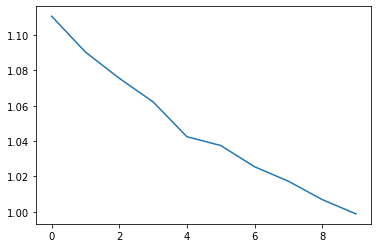

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['loss'])

In [47]:
def generate_output():
    generated = ''
    usr_input = input("Write down anything you want: ")

    sentence = ('{0:0>' + str(Tx) + '}').format(usr_input).lower()
    generated += usr_input 

    sys.stdout.write("\n\nHere is your fake Eminem song: \n\n") 
    sys.stdout.write(usr_input)
    for i in range(1000):

        x_pred = np.zeros((1, Tx, len(chars)))

        for t, char in enumerate(sentence):
            if char != '0':
                x_pred[0, t, char_indices[char]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature = 0.2)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()

        if next_char == '\n':
            continue

In [48]:
Tx = 40
generate_output()

Write down anything you want: love the way you lie


Here is your fake Eminem song: 

love the way you lie i love the way to let you hate to go we how me hold your can't shead and i take a couple stand up what i the couple when i'm gone could 'bout to go and i coul a tanged that shit i got a chanchts what i the matter i have to be the best to see with this mounk of nove of you massed me off all i don't know what he get to be the matter and so that i'm scarin' to say you can't see up and i can't see up and the couple stand the world get me one when i was not so bad in on my fath c moman call on my fatter that's where the shill on the same really so that i say that you have the way that i'm right i hate to the man but i got a chanchty as a roll you was just i got a chance back in this man that i can't see up and so that you'll be and i come me that i say that i the real slim shady please stand up but i got a chanchty call my lift as with a chaster and to that i can't see up and sound the

#### Conclusion:
1. Loss value decreased gradually with learning process
2. In general, the lyrics written by the text generator are still not human-like. 
   Possible reasons such as not enough learning data(I only use 30 songs, but that is maxium for my conputer to train), epoch also is too small, etc.